In [1]:
from json2dag.models.DAG import dag_from_causes_dict, model_from_dag
import numpy as np
import pymc as pm
from IPython.display import Image

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


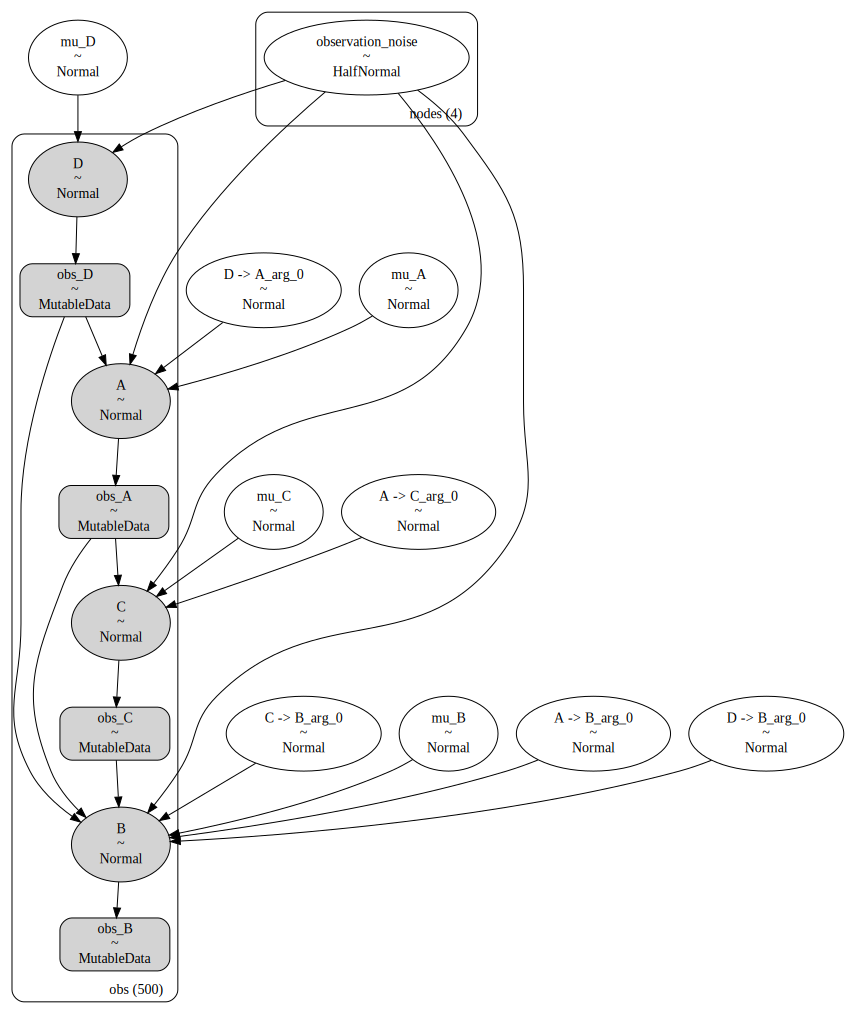

In [2]:
sample_size = 500
causes = {"A": [dict(name="B"), dict(name="C")], 
          "C": [dict(name="B")], 
          "D": [dict(name="B"), dict(name="A")]}
my_dag = dag_from_causes_dict(causes)

D = np.random.normal(0, 2, size=sample_size)
A = 10.0 + 2*D + np.random.normal(0, 2, size=sample_size)
C = 1.0 + 1*A + np.random.normal(0, 4, size=sample_size)
B = 3.0 + 2.0*A - 1.0*C - 2.0*D + np.random.normal(0, 1, size=sample_size)

sub_dag = dag_from_causes_dict({"D": causes["D"]})
my_dag_model = model_from_dag(my_dag, observations={'A': A, "B": B, "C": C, "D": D})
pm.model_to_graphviz(my_dag_model)

In [17]:
import dowhy
import pandas as pd

In [18]:
df = pd.DataFrame({"A": A, "B": B, "C": C, "D": D})

In [32]:
repr(my_dag).replace("\n\t", "; ").

'digraph {; A [label="A=obs_A"]; D [label="D=obs_D"]; C [label="C=obs_C"]; B [label="B=obs_B"]; A -> B [label="Linear Function"]; D -> A [label="Linear Function"]; D -> B [label="Linear Function"]; C -> B [label="Linear Function"]; A -> C [label="Linear Function"]\n}\n'

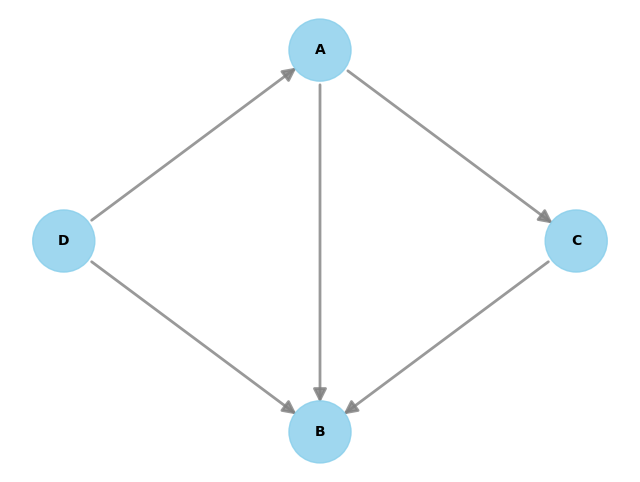

In [25]:
from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = df,
        graph=repr(my_dag).replace("\n", "; ").replace("{;", "{"),
        treatment='D',
        outcome='A')
model.view_model()

In [26]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[A])
d[D]      
Estimand assumption 1, Unconfoundedness: If U→{D} and U→A then P(A|D,,U) = P(A|D,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [31]:
estimands.estimands

{'backdoor1': {'estimand': Derivative(Expectation(A), [D]),
  'assumptions': {'Unconfoundedness': 'If U→{D} and U→A then P(A|D,,U) = P(A|D,)'}},
 'backdoor': {'estimand': Derivative(Expectation(A), [D]),
  'assumptions': {'Unconfoundedness': 'If U→{D} and U→A then P(A|D,,U) = P(A|D,)'}},
 'iv': None,
 'frontdoor': None}

In [28]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[A])
d[D]      
Estimand assumption 1, Unconfoundedness: If U→{D} and U→A then P(A|D,,U) = P(A|D,)

## Realized estimand
b: A~D
Target units: ate

## Estimate
Mean value: 2.0003097501112332



/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [29]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: Futur

Refute: Add a random common cause
Estimated effect:2.0003097501112332
New effect:2.0004102354334945
p value:0.98



/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: Futur

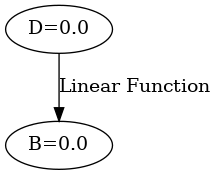

In [6]:
sub_dag = dag_from_causes_dict({"D": [causes["D"][0]]})
Image(sub_dag.graph)

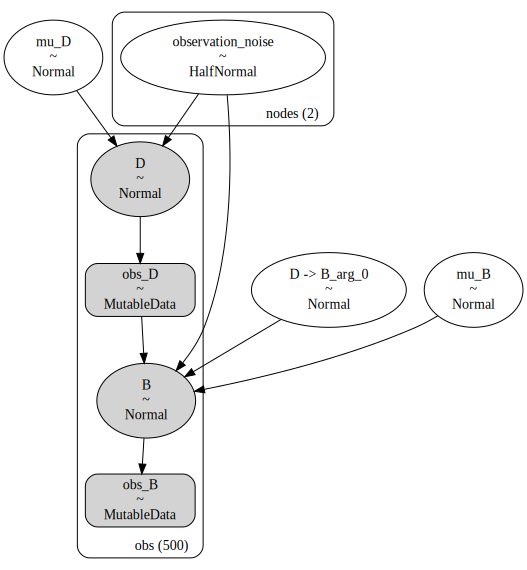

In [7]:
sub_dag_model = model_from_dag(sub_dag, observations={"B": B, "D": D})
pm.model_to_graphviz(sub_dag_model)

In [8]:
with sub_dag_model:
  sub_trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_noise, D -> B_arg_0, mu_D, mu_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
with my_dag_model:
  trace = pm.sample(1_000, tune=1_000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_noise, A -> B_arg_0, D -> A_arg_0, D -> B_arg_0, C -> B_arg_0, A -> C_arg_0, mu_A, mu_D, mu_C, mu_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [10]:
pm.summary(trace, filter_vars='regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A -> B_arg_0,2.022,0.026,1.972,2.071,0.001,0.000,2743.0,2314.0,1.0
D -> A_arg_0,1.996,0.046,1.912,2.086,0.001,0.000,5239.0,2908.0,1.0
D -> B_arg_0,-2.023,0.051,-2.122,-1.930,0.001,0.001,2813.0,2540.0,1.0
C -> B_arg_0,-0.996,0.012,-1.017,-0.973,0.000,0.000,4189.0,2798.0,1.0
A -> C_arg_0,1.027,0.037,0.956,1.094,0.001,0.000,3206.0,2840.0,1.0
mu_A,10.110,0.089,9.941,10.274,0.001,0.001,6409.0,2966.0,1.0
mu_D,-0.015,0.090,-0.191,0.146,0.001,0.001,5534.0,2917.0,1.0
mu_C,0.831,0.399,0.083,1.577,0.007,0.005,3290.0,2658.0,1.0
mu_B,2.679,0.234,2.217,3.098,0.004,0.003,2861.0,2515.0,1.0
observation_noise[A],2.033,0.064,1.917,2.155,0.001,0.001,5290.0,2676.0,1.0


In [11]:
pm.summary(sub_trace, filter_vars='regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D -> B_arg_0,0.025,0.101,-0.160,0.213,0.001,0.001,6526.0,3335.0,1.0
mu_D,-0.014,0.088,-0.177,0.149,0.001,0.001,6908.0,3074.0,1.0
mu_B,11.563,0.199,11.205,11.944,0.003,0.002,5592.0,3037.0,1.0
observation_noise[D],1.968,0.062,1.851,2.083,0.001,0.001,5703.0,2888.0,1.0
observation_noise[B],4.459,0.139,4.220,4.732,0.002,0.001,7074.0,3436.0,1.0


In [12]:
posterior = pm.sample_posterior_predictive(trace, model=my_dag_model)

Sampling: [A, B, C, D]


/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


array([<Axes: xlabel='A'>, <Axes: xlabel='D'>, <Axes: xlabel='C'>,
       <Axes: xlabel='B'>], dtype=object)

/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


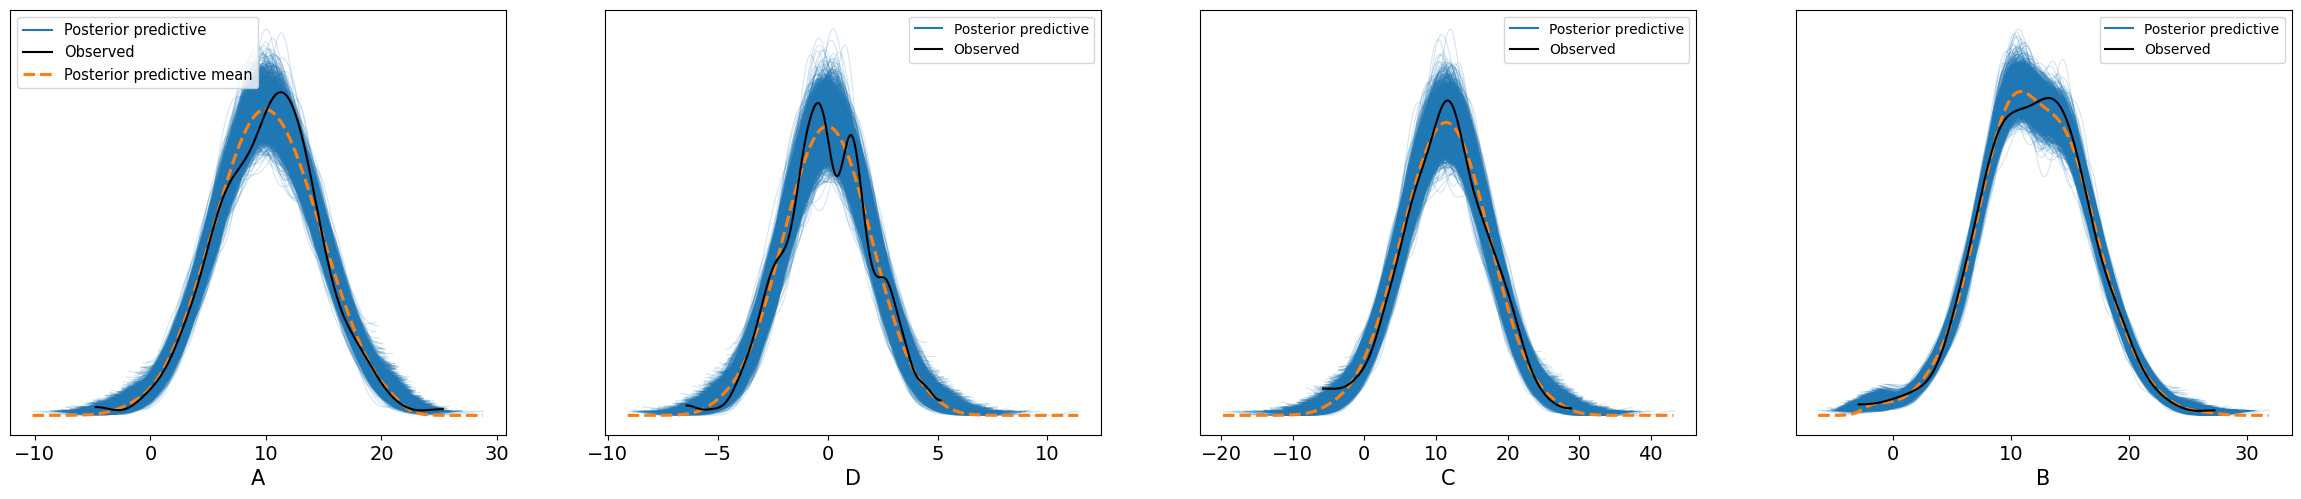

In [13]:
pm.plot_ppc(posterior)